<a href="https://colab.research.google.com/github/anuvind-saj/tensorflow-tutorials/blob/AI_ML/freeCodeCamp/Tensorflow_Tutorial_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q sklearn

In [ ]:
%tensorflow_version 2.x

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [ ]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [ ]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [ ]:
dftrain.shape

(627, 9)

In [ ]:
dftrain.corr()

,age,n_siblings_spouses,parch,fare
age,1.000000,-0.214280,-0.166974,0.119287
n_siblings_spouses,-0.214280,1.000000,0.430824,0.137795
parch,-0.166974,0.430824,1.000000,0.204204
fare,0.119287,0.137795,0.204204,1.000000


In [ ]:
dftrain.sample(20)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
19,male,28.0,0,0,7.2250,Third,unknown,Cherbourg,y
577,male,10.0,3,2,27.9000,Third,unknown,Southampton,n
397,male,28.0,0,0,7.8292,Third,unknown,Queenstown,y
446,female,21.0,0,0,77.9583,First,D,Southampton,y
50,male,4.0,3,2,27.9000,Third,unknown,Southampton,n
625,female,28.0,1,2,23.4500,Third,unknown,Southampton,n
538,female,51.0,1,0,77.9583,First,D,Southampton,n
6,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
537,male,20.0,0,0,7.2292,Third,unknown,Cherbourg,y
299,male,44.0,0,0,7.9250,Third,unknown,Southampton,y


In [ ]:
y_train.sample(20)

528    1
406    0
56     0
431    0
157    0
484    0
188    1
529    1
8      1
130    0
377    1
134    0
474    0
585    0
417    0
547    1
511    0
521    1
246    0
332    1
Name: survived, dtype: int64

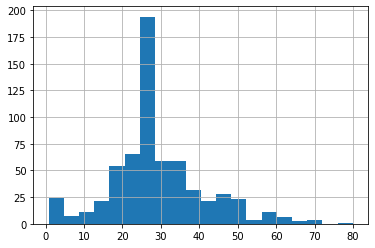

In [ ]:
dftrain.age.hist(bins = 20)

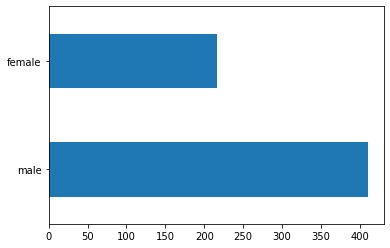

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

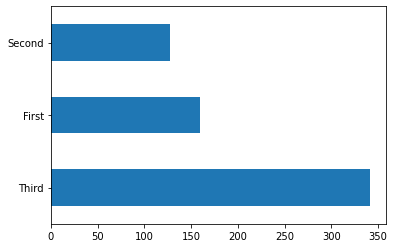

In [ ]:
dftrain['class'].value_counts().plot(kind='barh')

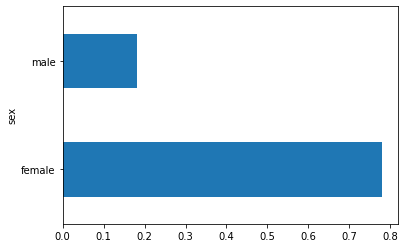

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh')

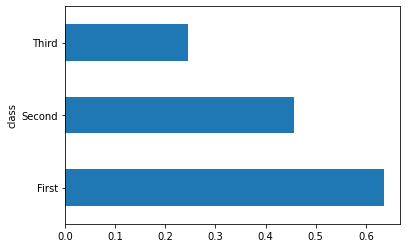

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('class').survived.mean().plot(kind='barh')

In [ ]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [ ]:
def make_input_fn(data_df, label_df, num_epochs= 10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

In [ ]:
train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3dppjpvt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.7462121


In [ ]:
print(result)

{'accuracy': 0.7462121, 'accuracy_baseline': 0.625, 'auc': 0.8206305, 'auc_precision_recall': 0.7896844, 'average_loss': 0.5553589, 'label/mean': 0.375, 'loss': 0.55336726, 'precision': 0.63114756, 'prediction/mean': 0.5193462, 'recall': 0.7777778, 'global_step': 200}


In [ ]:
pred_dicts = list(linear_est.predict(eval_input_fn))
print(pred_dicts)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3dppjpvt/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[{'logits': array([-1.4832146], dtype=float32), 'logistic': array([0.18494236], dtype=float32), 'probabilities': array([0.81505764, 0.18494235], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([1.029981], dtype=float32), 'logistic': array([0.73691225], dtype=float32), 'probabilities': array([0.26308778, 0.73691225], dtype=float32), 'class_ids': array([1]), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([2.531688], dtype=float32), 'logistic': array([0.9263336], dtype=float32), 'probabilities': array([0.07366638

0      0.184942
1      0.736912
2      0.926334
3      0.886088
4      0.501527
         ...   
259    0.897633
260    0.185434
261    0.782274
262    0.345072
263    0.605576
Length: 264, dtype: float64


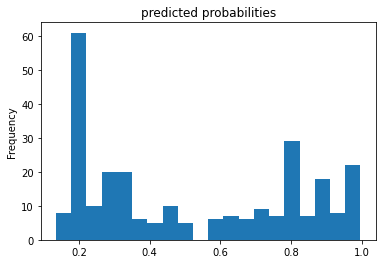

In [ ]:
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
print(probs)
probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

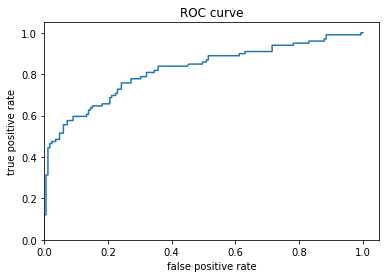

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)